### PCA-enhanced CVA (Canonical Variate Analysis)

Matlab code: https://uk.mathworks.com/matlabcentral/fileexchange/50938-a-benchmark-case-for-statistical-process-monitoring-cranfield-multiphase-flow-facility

Publications (PCA-enhanced CVA explained): 
* http://ijac.net/en/article/doi/10.1007/s11633-018-1142-y  (1)
* https://core.ac.uk/download/pdf/42144506.pdf  (2)

Publication with PCA-enhaned CVA used on Pronto dataset: https://www.sciencedirect.com/science/article/pii/S0959152418303603#bib0035  (3)

CVA is a linear dynamic feature extraction method from which the canonical variates with maximum correlation between past and future vectors can be acquired.

Instead of using original data matrix X , PCA-enhanced CVA algorithm adopts the principal components Y extracted by PCA as the input to CVA and get canonical variate matrix Z∈R n×d and residual matrix E∈R n×r. 


**Off-line training:**
1. Obtain normal operating data.
2. Mean centre data and normalize to unit variance (standartize data). 
3. Compute latent variables using PCA.
4. Obtain past (p) and future (f) Hankel matrices based on latent variables: Yp and Yf.
5. Perform SVD on the scaled Hankel matrix and determine number of states to retain.
6. Determine state variables and residuals.
7. Compute monitoring indices and their thresholds.


**On-line monitoring:**
1. Obtain and pre-process test data with same mean and standard deviation used for training data.
2. Compute latent variable of test data, and form past matrix.
3. Calculate state and residual.
4. Compute T^2k and Qk.
5. Monitor process by comparing values of T^2k and Qk against their thresholds. A fault is detect if either or both indices exceed their thresholds.

**Not solved challenges**:
1. **Normalization.** In the Matlab implementation (see Matlab code link above) normalization is performed after Hankel observation matrices are obtained ("CVA_Train" and "CVA_Monitor" functions here). The normalization code is commented out at the moment since this doesn't work: obtained results are not comparable. Instead the normalization step was implemented in "hankelpf" and "hankelp" functions. 
2. **Calculate DT (Detection Time)**, see attempt at the last section of this notebook. 

In [298]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report
from itertools import combinations
from sklearn.decomposition import PCA
from scipy.linalg import hankel
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde

## Load Pronto dataset

In [299]:
# PRONTO dataset
# Test day 2 (Fault: Air Blockage Test2, Test3 & Air Leakage Test4)
df1 = pd.read_csv("..\\data\\Testday2_merged.csv", sep = ",")
df1.head()

,FIC301,FIC302,LI405,LI502,PT312,VC303,VC401,VC403,VC404,VC405,...,P.topsep,FR.topsep.gas,FR.topsep.liquid,P_3phase,Air.Valve,Water.level,Water.coalescer,Water.level.valve,water.tank.level,Fault
0,0,0,1,0,0,0,0,0,0,0,...,1.027175,0.000491,0.064845,1.005916,25.092310,62.243111,98.642677,2.257356,1.443121,Normal
1,0,0,1,0,0,0,0,0,0,0,...,1.027277,0.000483,0.095639,1.006192,25.099390,62.235279,98.644371,2.278575,1.443152,Normal
2,0,0,1,0,0,0,0,0,0,0,...,1.028881,0.000476,0.095639,1.006467,25.106461,62.227440,98.646057,2.299793,1.443183,Normal
3,0,0,1,0,0,0,0,0,0,0,...,1.028640,0.000468,0.076789,1.006743,25.113529,62.219608,98.647758,2.321012,1.443214,Normal
4,0,0,1,0,0,0,0,0,0,0,...,1.028400,0.000461,0.076789,1.006743,25.120600,62.262520,98.649452,2.399387,1.443244,Normal


In [300]:
# Test day 3 (Fault: Air Leakage Test5, Test6 & Diverted Flow Test7, Test8)
df2 = pd.read_csv("..\\data\\Testday3_merged.csv", sep = ",")
df2.head()

,FIC301,FIC302,LI405,LI505,PT312,VC303,VC401,VC403,VC404,VC405,...,P.topsep,FR.topsep.gas,FR.topsep.liquid,P_3phase,Air.Valve,Water.level,Water.coalescer,Water.level.valve,water.tank.level,Fault
0,0,0,0,0,0,0,0,0,0,0,...,1.024576,0.090642,0.063302,1.004279,24.913710,61.413651,98.675041,0.162422,1.447658,Normal
1,0,0,0,0,0,0,0,0,0,0,...,1.024435,0.090642,0.072116,1.004258,24.917240,61.425671,98.671982,0.169636,1.447643,Normal
2,0,0,0,0,0,0,0,0,0,0,...,1.024295,0.061328,0.080931,1.004238,24.920759,61.440929,98.668907,0.176850,1.447628,Normal
3,0,0,0,0,0,0,0,0,0,0,...,1.024155,0.061328,0.082854,1.004217,24.924290,61.456188,98.665848,0.163235,1.447613,Normal
4,0,0,0,0,0,0,0,0,0,0,...,1.024014,0.040729,0.084776,1.004196,24.927820,61.471439,98.662781,0.149621,1.447598,Normal


In [301]:
df = pd.concat([df1, df2], ignore_index=True, sort=False)
df = df.dropna(axis='columns')
df = df.iloc[:,11:29] # removing alarms

In [302]:
# Due to the compression and quantization issues (see publication (3)),
# the temperature and density measurements (FT305-T, FT102-T and FT102-D) are removed.
# FT305-T	Input air temperature	°C (Air.T)
# FT102-T	Input water temperature	°C (Water.T)
# FT102-D	Input water density	kg m−3 (Water.Density)
df = df.drop(['Air.T','Water.T','Water.Density'],axis=1) 

## Create two subsets:  operating condition A and operating condition B, see publication (3)

In [303]:
# Operating condition A: 120 Sm3 h−1 air, 0.1 kg s−1 water flow rates
# Operating condition B: 150 Sm3 h−1 air, 0.5 kg s−1 water flow rates.
airA = 120
air_sd = df['AirIn'].std()
airB = 150

waterA = 0.1
water_sd = df['WaterIn'].std()
waterB = 0.5

In [304]:
testA = df[(df['AirIn']<=airA+air_sd) & (df['AirIn']>=airA-air_sd) & (df['WaterIn']<=waterA+water_sd) & (df['WaterIn']>=waterA-water_sd)]
testA.describe()

,AirIn,Air.P,WaterIn,Mixture.zone.P,riser.outlet.P,P.topsep,FR.topsep.gas,FR.topsep.liquid,P_3phase,Air.Valve,Water.level,Water.coalescer,Water.level.valve,water.tank.level
count,16308.000000,16308.000000,16308.000000,16308.000000,16308.000000,16308.000000,16308.000000,16308.000000,16308.000000,16308.000000,16308.000000,16308.000000,16308.000000,16308.000000
mean,119.772820,1.383078,0.097545,1.281389,1.017945,1.021418,0.095771,0.071741,1.000189,23.307934,61.831026,98.731932,2.295955,1.432547
std,2.315698,0.594256,0.005135,0.171539,0.050719,0.023610,1.209138,0.108823,0.023521,5.540345,1.142167,0.101725,2.687068,0.009571
min,102.966904,1.138369,0.091159,1.129860,0.920644,0.929620,0.000000,-2.879891,0.907659,0.473675,50.160221,98.352493,0.000000,1.413100
25%,118.931702,1.249580,0.095132,1.218456,1.010767,1.018300,0.000163,0.053559,0.997247,24.900022,61.769755,98.686327,1.398820,1.422634
50%,119.518204,1.276749,0.097175,1.229317,1.016489,1.020608,0.000375,0.068358,0.999314,25.061510,61.976429,98.718483,2.332684,1.430387
75%,120.619698,1.296556,0.099599,1.283959,1.021973,1.023461,0.001196,0.081438,1.002459,25.150372,62.124600,98.769920,2.946758,1.441751
max,137.027893,7.138096,0.243839,3.229707,2.732414,1.324794,31.880859,2.563764,1.303609,33.817669,75.299454,99.876007,48.951672,1.447881


In [305]:
testB = df[(df['AirIn']<=airB+air_sd) & (df['AirIn']>=airB-air_sd) & (df['WaterIn']<=waterB+water_sd) & (df['WaterIn']>=waterB-water_sd)]
testB.describe()

,AirIn,Air.P,WaterIn,Mixture.zone.P,riser.outlet.P,P.topsep,FR.topsep.gas,FR.topsep.liquid,P_3phase,Air.Valve,Water.level,Water.coalescer,Water.level.valve,water.tank.level
count,16035.000000,16035.000000,16035.000000,16035.000000,16035.000000,16035.000000,16035.000000,16035.000000,16035.000000,16035.000000,16035.000000,16035.000000,16035.000000,16035.000000
mean,149.949050,1.618649,0.496727,1.538002,1.113941,1.014170,5.507931,0.747982,0.991804,22.222423,61.857720,98.583863,7.421933,1.427155
std,2.084516,0.300978,0.013942,0.240872,0.089169,0.035203,3.652627,0.369621,0.034533,9.897779,1.240844,0.182677,3.462573,0.011996
min,133.017700,0.607549,0.300948,0.997974,0.820029,0.845333,0.000000,-4.607517,0.822942,0.030689,52.973598,97.675377,0.000000,1.393454
25%,148.381607,1.495869,0.496354,1.418648,1.078241,1.016609,1.496053,0.513504,0.994343,24.551280,61.832094,98.533588,7.421128,1.420514
50%,149.278107,1.674486,0.497705,1.455840,1.130932,1.021603,6.834418,0.717526,0.998893,27.343081,61.993111,98.632072,7.970311,1.425116
75%,151.538300,1.712556,0.499793,1.505571,1.163119,1.025204,7.987027,0.969553,1.002390,27.463650,62.127424,98.686626,8.229408,1.440040
max,157.742004,6.604678,0.528756,3.377301,2.905509,1.316939,43.671860,2.840868,1.294650,33.269218,72.624359,99.537453,47.577122,1.445096


In [306]:
# Attempt to replicate publication (3) results
# Operating condition A - testA
# Operating condition B - testB

# the False Alarm (FA) rates of the healthy condition data and 
# the detection time (DT) of the three faults obtained by PCA-enhanced CVA. 
# For operating condition A, the data from healthy operation with no induced faults 
# are divided into training and cross-validation sets. 
# The monitoring model is trained on the training set and the FA rate is calculated on the cross-validation set. 
# The FA rate for operating condition B is obtained in the same way.

# Select the healthy condition data
X_A = testA[testA['Fault']=='Normal'].iloc[:, :-1]
X_B = testB[testB['Fault']=='Normal'].iloc[:, :-1]

# Split into train and test (cross-validation) sets
X_trainA, X_testA = train_test_split(X_A)
X_trainB, X_testB = train_test_split(X_B)

## PCA-enhanced CVA model

In [384]:
# Parameters
a = 0.95 # Confidence level
variance_explained = 0.95 # PCA variance explanation level
p = 20 # length of past observation
f = 20 # length of future observation

In [385]:
# Matrix left and right division functions equivalent to Matlab functions

def mldivide(A,B): # A\B
    num_vars = A.shape[1]
    rank = np.linalg.matrix_rank(A)
    if rank == num_vars:              
        sol = np.linalg.lstsq(A, B, rcond=None)[0]    # not under-determined
    else:
        for nz in combinations(range(num_vars), rank):    # the variables not set to zero
            try: 
                sol = np.zeros((num_vars, 1))  
                sol[nz, :] = np.asarray(np.linalg.solve(A[:, nz], B))
            except np.linalg.LinAlgError:     
                pass                    # picked bad variables, can't solve
    return(sol)

# A/B = (B'\A')' A/B equivalent to np.linalg.solve(B.conj().T, A.conj().T).conj().T
def mrdivide(A,B): # A/B
    A_val = B.T
    B_val = A.T
    sol = mldivide(A_val,B_val)
    sol = sol.T
    return (sol)

In [386]:
# (4) Obtain past (p) and future (f) Hankel matrices

def hankelpf(y,p,f):
    # Constructing the past and future Hankel matrices
    # Inputs:
        #   y:  N x ny observed data with N observation points and ny variables.
        #   p:  the number of past observations
        #   f:  the number of future observations.
    # Outputs:
        #   Yp: the past Hankel matrix with dimension p*ny x M, M = N - p - f;
        #   Yf: the future Hankel matrix with dimension f*ny x M.

    [N,ny] = y.shape # number of observations
    m = N - p - f
    # Normalization values (not like in Matlab code)
    mean_values = y.mean()
    std_values = y.std()
    
    # original Matlab code:  Ip = flipud(hankel(1:p,p:N-f)) 
    Ip = np.flipud(hankel(list(range(0,p)),list(range(p,N-f)))) #indices of past observations
    # original Matlab code: Yp = reshape(y(Ip,:)',ny*p,[])
    # Normalization performed here (not like in Matlab code)
    values_past = np.array([[np.array((y.iloc[Ip[j,i]]-mean_values)/std_values) for j in range(p)] for i in range(m)])
    Yp = np.reshape(np.transpose(values_past, (2, 1, 0)),(ny*p,m))
    # original Matlab code:  If = hankel(p+1:p+f,p+f:N)
    If = np.flipud(hankel(list(range(p,p+f)),list(range(p+f,N)))) #indices of future observations
    # original Matlab code:  Yf = reshape(y(If,:)',ny*f,[]) 
    # Normalization performed here (not like in Matlab code)
    values_future = np.array([[np.array((y.iloc[If[j,i]]-mean_values)/std_values) for j in range(f)] for i in range(m)])
    Yf = np.reshape(np.transpose(values_future, (2, 1, 0)),(ny*f,m))
    return (Yp,Yf)

def hankelp(y,p,f=0):
    # Constructing the past Hankel matrix
    # Inputs:
        #   y:  N x ny observed data with N observation points and ny variables.
        #   p:  the number of past observations
        #   f:  the number of future observations.
    # Outputs:
        #   Yp: the past Hankel matrix with dimension p*ny x M, M = N - p - f;

    [N,ny] = y.shape # number of observations
    m = N - p - f
    # Normalization values (not like in Matlab code)
    mean_values = y.mean()
    std_values = y.std()
    
    # original Matlab code:  Ip = flipud(hankel(1:p,p:N-f)) 
    Ip = np.flipud(hankel(list(range(0,p)),list(range(p,N-f)))) #indices of past observations
    # original Matlab code: Yp = reshape(y(Ip,:)',ny*p,[]) 
    # Normalization performed here (not like in Matlab code)
    values_past = np.array([[np.array((y.iloc[Ip[j,i]]-mean_values)/std_values) for j in range(p)] for i in range(m)])
    Yp = np.reshape(np.transpose(values_past, (2, 1, 0)),(ny*p,m))
    return (Yp)

In [387]:
# Kernel Density Estimation with Scipy to predict PDF from data points
def kde_scipy(x, bandwidth=0.2):
    N = 100
    p_h = np.median(abs(x-np.median(x)))*1.5704/pow(x.shape[0],0.2)
    dx = p_h*3
    p_n = 0
    p_x = np.linspace(min(x)-dx,max(x)+dx,N)
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1))
    p_f = kde.evaluate(p_x)
    return (p_x,p_f)

### PCA-enhanced CVA Training phase

In [388]:
def CVA_Train(X):
    # (2) Standardizing the features
    X_st = StandardScaler().fit_transform(X)
    
    # (3) PCA transformation to obtain Linear Latent Variables (Y) and dimentionality reduction to explain 95% of original variance
    # Dimentionality reduction to explain ('variance_explained'*100)% of variance
    pca = PCA(n_components=variance_explained, svd_solver='full')
    # PCA data transformation
    X_pca = pca.fit_transform(X_st)
    # numpy array to pandas data frame
    Y = pd.DataFrame(data = X_pca)
    # get number of components
    n_pcs= pca.components_.shape[0]
    
    # (4) Get Hankel observation matrices
    [Yp, Yf] = hankelpf(Y,p,f)
    # Normalise observation matrices
    pn = Yp.shape[1] # pn = size(Yp,2)
    # Code below doesn't work! See Challenges at the top.
    #pmean = Yp.mean(axis=1, keepdims=True) #Matlab: pmean = mean(Yp,2);
    #pstd = Yp.std(axis=1, keepdims=True) #Matlab: pstd = std(Yp,0,2);
    #fmean = Yf.mean(axis=1, keepdims=True) #Matlab: fmean = mean(Yf,2);
    #fstd = Yf.std(axis=1, keepdims=True) #Matlab: fstd = std(f,0,2);
    #Yp = mrdivide(np.subtract(Yp,pmean),pstd) #Matlab: Yp = (Yp - pmean(:,ones(1,pn)))./pstd(:,ones(1,pn));
    #Yf = mrdivide(np.subtract(Yf,fmean),fstd) #Matlab: Yf = (Yf - fmean(:,ones(1,pn)))./fstd(:,ones(1,pn));
    
    # (5) Obtain Cholesky matrices and Hankel matrix. Perform SVD
    # Past Cholesky matrix Rp = chol(Yp*Yp'/(pn-1)); 
    Rp = np.linalg.cholesky(np.matmul(Yp,Yp.T)/(pn-1))
    # Future Cholesky matrix Rf = chol(Yf*Yf'/(pn));
    Rf = np.linalg.cholesky(np.matmul(Yf,Yf.T)/(pn))
    # Cross-covariance matrix Hfp = Yf*Yp'/pn; 
    Hfp = np.matmul(Yf,Yp.T)/pn
    # Hankel matrix H = (Rf'\Hfp)/Rp;
    H1 = mldivide(Rf.T,Hfp)
    H = mrdivide(H1,Rp)
    # CVA seeks to find linear combinations of the future observations that correlate the most with the past observations
    # This can be done with SVD on Hankel matrix H
    # SVD [~,S,V] = svd(H);
    [U, S, V] = np.linalg.svd(H, full_matrices=True)
    
    # Based on singular values (S) that explain most of the variance we want to select q associated 
    # singular vectors of V, the ones that have the largest correlations with those of U.
    var_explained = np.round(S**2/np.sum(S**2), decimals=3)*100
    #sns.barplot(x=list(range(1,len(var_explained)+1)), y=var_explained, color="limegreen")
    #plt.xlabel('SVs', fontsize=16)
    #plt.ylabel('Percent Variance Explained', fontsize=16)
    
    # (6) Determine state variables and residuals
    # S = diag(S);
    S = np.diag(S)
    # m = numel(S);
    m = S.shape[0]
    # Reduced V matrix V1 = V(:,1:n); where n < ny*p 
    n = S[var_explained>0.5].shape[0]
    V1 =  V[:,0:n-1]   
    # Transformation matrix of state variables J = V1'/Rp';  
    J = mrdivide(V.T,Rp.T)   
    # Transformation matrix of residuals L = (eye(m)-V1*V1')/Rp';  
    L = mrdivide((np.eye(m)-np.matmul(V,V.T)),Rp.T)
    # The canonical variate vector z and residual vector e are both linear projections of past vector yp at time t
    # States of training data z = J * Yp;
    z = np.matmul(J, Yp)
    # Residuals of training data e = L * Yp;
    e = np.matmul(L, Yp)
    # The Hotellings T^2 and the Q statistic or squared prediction (SPE) and their control limits are used for process monitoring
    #T^2 of training data T = sum(z.*z);  
    T = sum(np.multiply(z,z))
    # Q statistic of training data Q = sum(e.*e);
    Q = sum(np.multiply(e,e))
    
    # (7) Compute monitoring indices
    # Compute kde (kernel density estimation) based control limits
    # KDE of T^2 Tp = gkde(T); 
    [Tp_x,Tp_f] = kde_scipy(T, bandwidth=0.2)
    # KDE of Q statistic Qp = gkde(Q);      
    [Qp_x,Qp_f] = kde_scipy(Q, bandwidth=0.2)
    # T^2 Probability Tf=cumsum([0;diff(Tp.x(:))].*Tp.f(:));
    Tf = np.cumsum(np.multiply(np.insert(np.diff(Tp_x),0,0),Tp_f))
    # Q Probability Qf=cumsum([0;diff(Qp.x(:))].*Qp.f(:));   
    Qf = np.cumsum(np.multiply(np.insert(np.diff(Qp_x),0,0),Qp_f))
    
    # Plot the Hotellings T^2 PDF predicted by kde
    #fig, ax = plt.subplots()
    #ax.plot(Tp_x, Tp_f, color='green', alpha=0.5, lw=3)
    # Plot SPE's PDF predicted by kde
    #fig, ax = plt.subplots()
    #ax.plot(Qp_x, Qp_f, color='blue', alpha=0.5, lw=3)
    
    # (7) Compute monitoring thresholds
    # Control limit of T^2 Ta = max(Tp.x(Tf<=a)); 
    Ta = max(Tp_x[Tf<=a]) 
    # Control limit of Q statistic Qa = max(Qp.x(Qf<=a)); 
    Qa = max(Qp_x[Qf<=a])
    
    return (pca,J,L,Ta,Qa)

### PCA-enhanced CVA Monitoring phase

In [389]:
def CVA_Monitor(X, pca, J, L):
    # PCA transform test data
    X_pca_test = pca.transform(X.values)
    Y_pca_test = pd.DataFrame(data = X_pca_test)
    
    # Construct past obseravtion matrix of test data
    Ypm = hankelp(Y_pca_test,p)
    # Normalise past test observation matrix
    # Code below doesn't work! See Challenges at the top.
    #pmean = Ypm.mean(axis=1, keepdims=True) #Matlab: pmean = mean(Yp,2);
    #pstd = Ypm.std(axis=1, keepdims=True) #Matlab: pstd = std(Yp,0,2);
    #Ypmn = mrdivide(np.subtract(Ypm,pmean),pstd) #Matlab: Ypmn = (Ypmn - pmean(:,ones(1,pn)))./pstd(:,ones(1,pn));

    # Compute T^2 and Q indicators for monitoring
    # States of test data
    zk = np.matmul(J,Ypm)    
    # Tsquare of test data
    T2mon = sum(np.multiply(zk,zk)) 
    # Residuals of test data
    ek = np.matmul(L,Ypm)      
    #Q statistic of test data
    Qmon = sum(np.multiply(ek,ek))
    
    return(T2mon, Qmon)

## Calculate FA (False Alarm) rates for Test A and Test B

FA rate for Test A 23.223570190641247


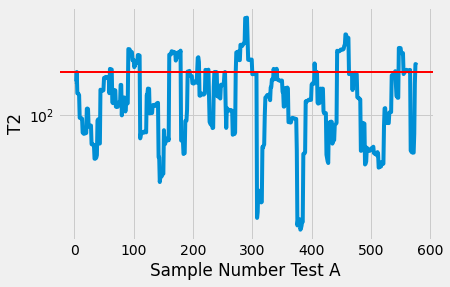

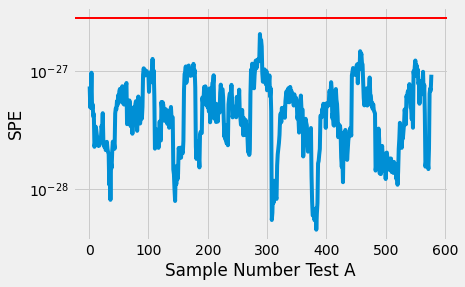

In [390]:
# The monitoring model is trained on the training set and the FA (False Alarm) rate is calculated on the cross-validation set.

# TestA
[pca_A,J_A,L_A,Ta_A,Qa_A] = CVA_Train(X_trainA)
[T2mon_A,Qmon_A] = CVA_Monitor(X_testA,pca_A,J_A,L_A)
FA_A = 100 * np.count_nonzero(T2mon_A[(T2mon_A>=Ta_A) | (Qmon_A>=Qa_A)])/np.count_nonzero(T2mon_A)
print('FA rate for Test A', FA_A)

N=T2mon_A.shape[0]
fig, ax = plt.subplots()
plt.xlabel('Sample Number Test A')
plt.ylabel('T2')
ax.semilogy(list(range(1,N+1)), T2mon_A)
ax.axhline(y=Ta_A,linewidth=2, color='red')
plt.show()
    
fig, ax = plt.subplots()
plt.xlabel('Sample Number Test A')
plt.ylabel('SPE')
ax.semilogy(list(range(1,N+1)), Qmon_A)
ax.axhline(y=Qa_A,linewidth=2, color='red')
plt.show()

FA rate for Test B 13.172541743970315


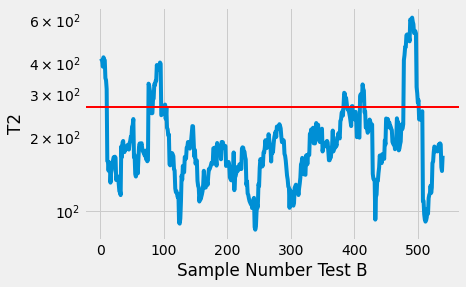

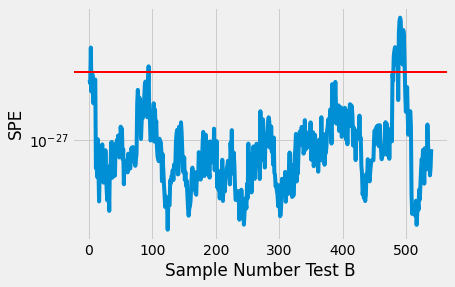

In [391]:
# TestB
[pca_B,J_B,L_B,Ta_B,Qa_B] = CVA_Train(X_trainB)
[T2mon_B,Qmon_B] = CVA_Monitor(X_testB,pca_B,J_B,L_B)
FA_B = 100 * np.count_nonzero(T2mon_B[(T2mon_B>=Ta_B) | (Qmon_B>=Qa_B)])/np.count_nonzero(T2mon_B)
print('FA rate for Test B', FA_B)

N=T2mon_B.shape[0]
fig, ax = plt.subplots()
plt.xlabel('Sample Number Test B')
plt.ylabel('T2')
ax.semilogy(list(range(1,N+1)), T2mon_B)
ax.axhline(y=Ta_B,linewidth=2, color='red')
plt.show()
    
fig, ax = plt.subplots()
plt.xlabel('Sample Number Test B')
plt.ylabel('SPE')
ax.semilogy(list(range(1,N+1)), Qmon_B)
ax.axhline(y=Qa_B,linewidth=2, color='red')
plt.show()

## Calculate DT (Detection Time) for Test A and Test B
For fault detection in operating condition A, the T^2 and SPE values of the faulty data sets, which are collected with manually induced faults, are calculated and compared with their control limits using the monitoring model trained for the same operating condition. 

A fault is defined to be detected once at least one of the monitoring statistics exceeds its control limit for more than 20 samples. 

The DT is defined as the time difference between inducing the fault and detecting the fault. DTs for operating condition B is obtained in the same way.

In [392]:
# Create faulty data sets
# Test A (faulty dataset):
X_A = testA.iloc[:, :-1]
y_A = testA['Fault']
# Test B (faulty dataset):
X_B = testB.iloc[:, :-1]
y_B = testB['Fault']

In [393]:
# Calculate T^2 and SPE (Q) for faulty dataset test A using previosly trained CVA model for test A
[T2mon_FaultyA,Qmon_FaultyA] = CVA_Monitor(X_A,pca_A,J_A,L_A)

In [554]:
# Let's assume that our predictions are correspomding to vector Yp = [yp,p+1,...,yp,p+m] 
# that in turn correspond to y_A[21:16308]

In [560]:
y = y_A[p:y_A.shape[0]].values
N=T2mon_FaultyA.shape[0]
index_changes = np.where(np.roll(y,1)!=y)[0] #np.where(y[:-1] != y[1:])[0]
index_changes = np.insert(index_changes,0,0)
index_changes = np.insert(index_changes,index_changes.shape[0],y.shape[0]-1)
xcoords = index_changes
xvalues = y[index_changes]

index_changes

array([    0,   341,  4060,  4960,  7841,  8931, 16251, 16287],
      dtype=int64)

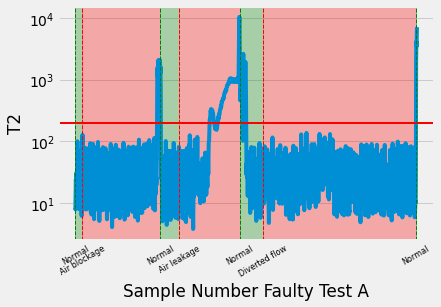

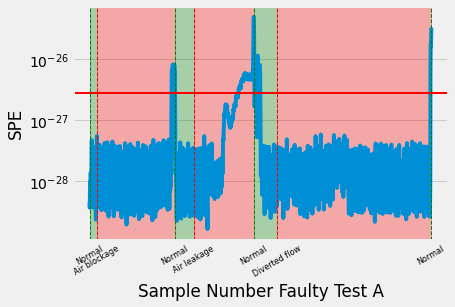

In [561]:
fig, ax = plt.subplots()
plt.xlabel('Sample Number Faulty Test A')
plt.ylabel('T2')
ax.semilogy(list(range(1,N+1)), T2mon_FaultyA)
ax.axhline(y=Ta_A,linewidth=2, color='red')
for x in range(len(xcoords)-1):
    if xvalues[x]=='Normal':
        color_val = 'g'
    else:
        color_val = 'r'
    ax.axvspan(xcoords[x], xcoords[x+1]-1, facecolor=color_val, alpha=0.3)
    ax.axvline(x=xcoords[x], color=color_val,lw=1, linestyle='dashed')
ax.set_xticks(xcoords[0:len(xcoords)-1])
ax.set_xticklabels(xvalues[0:len(xcoords)-1], rotation = 30, fontsize=8)
plt.show()

fig, ax = plt.subplots()
plt.xlabel('Sample Number Faulty Test A')
plt.ylabel('SPE')
ax.semilogy(list(range(1,N+1)), Qmon_FaultyA)
ax.axhline(y=Qa_A,linewidth=2, color='red')
for x in range(len(xcoords)-1):
    if xvalues[x]=='Normal':
        color_val = 'g'
    else:
        color_val = 'r'
    ax.axvspan(xcoords[x], xcoords[x+1]-1, facecolor=color_val, alpha=0.3)
    ax.axvline(x=xcoords[x], color=color_val,lw=1, linestyle='dashed')
ax.set_xticks(xcoords[0:len(xcoords)-1])
ax.set_xticklabels(xvalues[0:len(xcoords)-1], rotation = 30, fontsize=8)
plt.show()

In [395]:
# Calculate T^2 and SPE (Q) for faulty dataset test B using previosly trained CVA model for test B
[T2mon_FaultyB,Qmon_FaultyB] = CVA_Monitor(X_B,pca_B,J_B,L_B)

In [565]:
y = y_B[p:y_B.shape[0]].values
N=T2mon_FaultyB.shape[0]
index_changes = np.where(np.roll(y,1)!=y)[0] #np.where(y[:-1] != y[1:])[0]
#index_changes = np.insert(index_changes,0,0)
index_changes = np.insert(index_changes,index_changes.shape[0],y.shape[0]-1)
xcoords = index_changes
xvalues = y[index_changes]

index_changes

array([    0,  4226,  4587,  7405,  8850, 11389, 11816, 16014],
      dtype=int64)

In [584]:
xvalues

array(['Air blockage', 'Normal', 'Air leakage', 'Normal', 'Air leakage',
       'Normal', 'Diverted flow', 'Diverted flow'], dtype=object)

In [631]:
def first_subseq(new_list,length_threshold):
    subseq = [[]]
    subseq2 = [[]]
    for e in new_list:
        if not subseq[-1] or (e-subseq[-1][-1]) == 1:
            subseq[-1].append(e)
        else:
            subseq.append([e])
    for row in subseq:
        if (len(row)>=length_threshold):
            #print (len(row))
            subseq2.append(row)
    print(subseq2.size())
    if (np.array(subseq2).size>0):
        return (subseq2[1])
    else:
        return ([])
new_list= [0, 25, 2, 1, 2, 1, 14, 1, 4, 6, 6, 7, 8, 9, 11]
first_subseq(new_list,3)

AttributeError: 'list' object has no attribute 'size'

In [630]:
DT = np.zeros(N)
DT_real = np.zeros(N)
for i in range(N):
    if (T2mon_FaultyB[i]>=Ta_B) | (Qmon_FaultyB[i]>=Qa_B):
        DT[i] = 1

    if (y[i]!='Normal'):
        DT_real[i] = 1
        
j = 1
for i in index_changes:
    if (j < index_changes.shape[0]):
        print(i,(index_changes[j]-1))
        print(xvalues[j-1])
        occurrences_of_one = np.where(DT[i:(index_changes[j]-1)]==1.0)
        if (np.array(occurrences_of_one).shape[1]>0):
            res = first_subseq(occurrences_of_one,20)
            print(res)
            first_occurrence_of_one = occurrences_of_one[0][0]
            print('Fault is detected at time ', first_occurrence_of_one + i)
        else:
            print('Fault is not detected!')
    j += 1

0 4225
Air blockage


AttributeError: 'list' object has no attribute 'size'

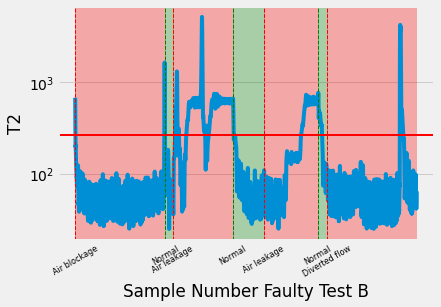

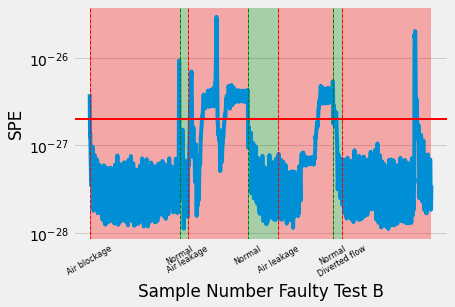

In [552]:
fig, ax = plt.subplots()
plt.xlabel('Sample Number Faulty Test B')
plt.ylabel('T2')
ax.semilogy(list(range(1,N+1)), T2mon_FaultyB)
ax.axhline(y=Ta_B,linewidth=2, color='red')
for x in range(len(xcoords)-1):
    if xvalues[x]=='Normal':
        color_val = 'g'
    else:
        color_val = 'r'
    ax.axvspan(xcoords[x], xcoords[x+1]-1, facecolor=color_val, alpha=0.3)
    ax.axvline(x=xcoords[x], color=color_val,lw=1, linestyle='dashed')
ax.set_xticks(xcoords[0:len(xcoords)-1])
ax.set_xticklabels(xvalues[0:len(xcoords)-1], rotation = 30, fontsize=8)
plt.show()

fig, ax = plt.subplots()
plt.xlabel('Sample Number Faulty Test B')
plt.ylabel('SPE')
ax.semilogy(list(range(1,N+1)), Qmon_FaultyB)
ax.axhline(y=Qa_B,linewidth=2, color='red')
for x in range(len(xcoords)-1):
    if xvalues[x]=='Normal':
        color_val = 'g'
    else:
        color_val = 'r'
    ax.axvspan(xcoords[x], xcoords[x+1]-1, facecolor=color_val, alpha=0.3)
    ax.axvline(x=xcoords[x], color=color_val,lw=1, linestyle='dashed')
ax.set_xticks(xcoords[0:len(xcoords)-1])
ax.set_xticklabels(xvalues[0:len(xcoords)-1], rotation = 30, fontsize=8)
plt.show()

Now how to calculate DT?

Records (rows) in T2mon_FaultyA, T2mon_FaultyB etc. matrices represent the state of p samples:
* first row: 0-15 samples of original matrix X, 
* second row: 1-16 samples of original matrix X, 
* ..., 
* 16020-16035 samples of original matrix X

How to compare T2mon_FaultyB results that are above the threshold (Ta_B) and y_B values?

In [563]:
# Attempt to transform T2mon_Faulty and Qmon_Faulty into the form that is comparable with original fault status vector (y_A, y_B)
y = y_B[p:y_B.shape[0]].values
N = T2mon_FaultyB.shape[0]
i = 0
j = p
#DT = np.zeros(N+p)
DT = np.zeros(N)
DT_real = np.zeros(N)
while (i<=(N-1)):
    if (T2mon_FaultyB[i]>=Ta_B) | (Qmon_FaultyB[i]>=Qa_B):
        #DT[i:j] += 1
        DT[i] = 1

    if (y[i]!='Normal'):
        DT_real[i] = 1
    i += 1
    j += 1

r = np.corrcoef (DT_real,DT)
print(r[0,1])

0.11566673233589547


In [537]:

index_changes = np.where(np.roll(y,1)!=y)[0] #np.where(y[:-1] != y[1:])[0]
#index_changes = np.insert(index_changes,0,0)
index_changes = np.insert(index_changes,index_changes.shape[0],y.shape[0]-1)
index_changes

array([    0,  4226,  4587,  7405,  8850, 11389, 11816, 16014],
      dtype=int64)

In [486]:
# The DT is defined as the time difference between inducing the fault and detecting the fault.
# Inducing the fault 
fault_induced = np.where(np.roll(y,1)!=y)[0] 
#y[fault_induced]
fault_induced[np.where(y[fault_induced]!='Normal')]

array([ 341, 4960, 8931], dtype=int64)

In [514]:
# Detecting the fault
fault_detected = np.where(np.roll(DT,1)!=DT)[0] 
fault_detected
status_change = [abs(j-i) for i,j in zip(fault_detected, fault_detected[1:])]
status_change = np.insert(status_change,0,1)

j = 0
for i in range(len(status_change)):
    if status_change[i]==1:
        j += 1
    else:
        if j >= p-1:
            print(fault_detected[i])
        j = 0
        
#status_change = [abs(j-i)!=1 for i,j in zip(fault_detected, fault_detected[1:])]
#status_change = np.insert(status_change,0,True)
#fault_detected[status_change]
# Air blockage 4078-361 = 3717, Air leakage 6399-4980 = 1419, Diverted flow 16239-8951 = 7288

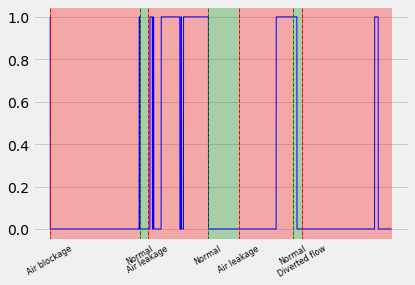

In [538]:
xcoords = index_changes
xvalues = y[index_changes]

plt.style.use("fivethirtyeight")
fig, axs = plt.subplots()
#axs.scatter(list(range(len(DT))), DT, color='blue', s=1)
axs.plot(DT, color='blue',linewidth=1)
for x in range(len(xcoords)-1):
    if xvalues[x]=='Normal':
        color_val = 'g'
    else:
        color_val = 'r'
    axs.axvspan(xcoords[x], xcoords[x+1]-1, facecolor=color_val, alpha=0.3)
    axs.axvline(x=xcoords[x], color=color_val,lw=1, linestyle='dashed')
        
axs.set_xticks(xcoords[0:len(xcoords)-1])
axs.set_xticklabels(xvalues[0:len(xcoords)-1], rotation = 30, fontsize=8)
plt.show()